In [1]:
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
import matplotlib.pyplot as plt
from numpy import ravel

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPClassifier
import itertools

import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import random

import scipy

from sklearn.preprocessing import StandardScaler  


# Set seed
random.seed(2020)
np.random.seed(2020)

In [2]:
from math import sqrt

def wilson_ci( pi, n, alpha ):
  a = 2 * n * pi + scipy.stats.norm.ppf(1 - alpha/2)**2
  b = scipy.stats.norm.ppf(1 - alpha/2) * sqrt(scipy.stats.norm.ppf(1 - alpha/2)**2 + 4 * n * pi * (1 - pi))
  d = 2 * (n + scipy.stats.norm.ppf(1 - alpha/2)**2)
  
  res  = round((a - b)/d, 3)
  res2 = round((a + b) / d, 3)
  
  return [res, res2]

In [3]:
A = pd.read_excel("mortality_all.xlsx")
print(A.shape)

y = A["Mortality"]
y = y.ravel()
print(y.shape)


sts = A["STS"]
sts = np.array(sts, dtype = float)

sts_2 = A["STSACC"]
sts_2 = np.array(sts_2, dtype = float)

X = A
del X["Mortality"]
del X["ID"]
del X["STS"]
del X["STSACC"]
X = np.array(X, dtype = float)
print(X.shape)

(451, 87)
(451,)
(451, 83)


In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)
X = pd.DataFrame(data = X) # Create data frame

feature_scaler = StandardScaler()  
X = feature_scaler.fit_transform(X)

In [5]:
X1 = pd.read_excel("Baseline August (30 features + ID).xlsx")
X1 = np.array(X1, dtype = float)
X1 = imp.fit_transform(X1)
X1 = pd.DataFrame(data = X1) # Create data frame
X1 = feature_scaler.fit_transform(X1)  
print(X1.shape)

(451, 51)


In [6]:
spez = 0.9
pos = len(y[np.where(y==1)])
neg = len(y) - pos

In [7]:
fpr, tpr, thresholds = metrics.roc_curve(y, ravel(sts/100))
auc_sts = auc(fpr, tpr)

print('AUC:', auc_sts)
print('Confidence Interval:', wilson_ci (auc_sts, len(y), 0.05))

AUC: 0.6365258215962442
Confidence Interval: [0.591, 0.68]


In [8]:
sens_sts = tpr[np.argmin(fpr < 1-spez)]
acc_sts  = (sens_sts * pos + spez * neg) / len(y)
print('Accuracy:', acc_sts)
print('Sensitivity:', sens_sts)

Accuracy: 0.8545454545454546
Sensitivity: 0.08


In [9]:
fpr, tpr, thresholds = metrics.roc_curve(y, ravel(sts_2/100))
auc_sts_2 = auc(fpr, tpr)

print('AUC:', auc_sts_2)
print('Confidence Interval:', wilson_ci (auc_sts_2, len(y), 0.05))

AUC: 0.6501877934272301
Confidence Interval: [0.605, 0.693]


In [10]:
sens_sts2 = tpr[np.argmin(fpr < 1-spez)]
acc_sts2  = (sens_sts2 * pos + spez * neg) / len(y)
print('Accuracy:', acc_sts2)
print('Sensitivity:', sens_sts2)

Accuracy: 0.858980044345898
Sensitivity: 0.16


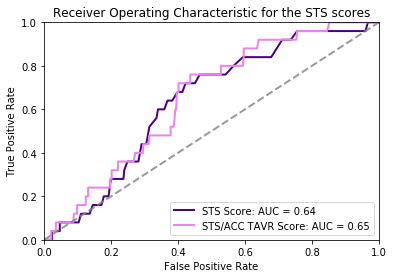

In [11]:
fpr, tpr, threshold = metrics.roc_curve(y, sts)
roc_auc = metrics.auc(fpr, tpr)
std_auc = np.std(roc_auc)
plt.plot(fpr, tpr, color='indigo', lw=2, label = 'STS Score: AUC = %0.2f' % roc_auc)

fpr, tpr, threshold = metrics.roc_curve(y, sts_2)
roc_auc = metrics.auc(fpr, tpr)
std_auc = np.std(roc_auc)
plt.plot(fpr, tpr, color='violet', lw=2, label = 'STS/ACC TAVR Score: AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic for the STS scores')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         label='Chance', alpha=.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=4)

In [13]:
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=4)
cv = outer_cv

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1 ,max_features= 'sqrt' ,n_estimators=50, 
                             oob_score = True, class_weight = {1: 18}) 

grid_param_rf = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

classifier_rf = GridSearchCV(estimator=rfc, param_grid=grid_param_rf, cv=inner_cv, scoring='roc_auc')

In [15]:
probas_rf  = ravel(np.zeros(len(y)))
probas_rfb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_rf.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_rf[test] = probs[:, 1]
    fit   = classifier_rf.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_rfb[test] = probs[:, 1]

    
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, probas_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_rfb, tpr_rfb, thresholds_rfb = roc_curve(y, probas_rfb)
auc_rfb = auc(fpr_rfb, tpr_rfb)

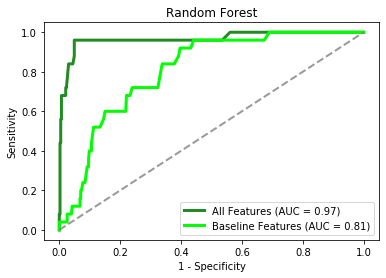

In [16]:
plt.plot(fpr_rf, tpr_rf, lw=3, alpha=1, color='forestgreen',
         label='All Features (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_rfb, tpr_rfb, lw=3, alpha=1, color='lime',
         label='Baseline Features (AUC = %0.2f)' % auc_rfb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Random Forest")
plt.show()

In [17]:
sens_rf = tpr_rf[np.argmin(fpr_rf < 1 - spez)]
acc_rf  = (sens_rf * pos + spez * neg) / len(y)
print('AUC:', auc_rf)
print('Confidence Interval:', wilson_ci (auc_rf, len(y), 0.05))
print('Accuracy:', acc_rf)
print('Sensitivity:', sens_rf)
print('Specificity:', spez)

AUC: 0.9659154929577465
Confidence Interval: [0.945, 0.979]
Accuracy: 0.9033259423503327
Sensitivity: 0.96
Specificity: 0.9


In [18]:
sens_rfb = tpr_rfb[np.argmin(fpr_rfb < 1 - spez)]
acc_rfb  = (sens_rfb * pos + spez * neg) / len(y)
print('AUC:', auc_rfb)
print('Confidence Interval:', wilson_ci (auc_rfb, len(y), 0.05))
print('Accuracy:', acc_rfb)
print('Sensitivity:', sens_rfb)
print('Specificity:', spez)

AUC: 0.8069014084507042
Confidence Interval: [0.768, 0.841]
Accuracy: 0.8722838137472284
Sensitivity: 0.4
Specificity: 0.9


In [19]:
NeuralNetwork = MLPClassifier(solver='sgd', alpha=1e-5, max_iter = 10000,
                    hidden_layer_sizes=(5, 2), random_state=1)
grid_param_nn = {  
    'activation': ['logistic','tanh','relu'],
    'learning_rate': ['constant','invscaling'],
    'hidden_layer_sizes':[x for x in itertools.product((3,4,5),repeat=3)]
}

classifier_nn = GridSearchCV(estimator=NeuralNetwork, param_grid=grid_param_nn, cv=inner_cv, scoring='roc_auc')

In [20]:
probas_nn  = ravel(np.zeros(len(y)))
probas_nnb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_nn.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_nn[test] = probs[:, 1]
    fit = classifier_nn.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_nnb[test] = probs[:, 1]

    
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y, probas_nn)
auc_nn = auc(fpr_nn, tpr_nn)

fpr_nnb, tpr_nnb, thresholds_nnb = roc_curve(y, probas_nnb)
auc_nnb = auc(fpr_nnb, tpr_nnb)

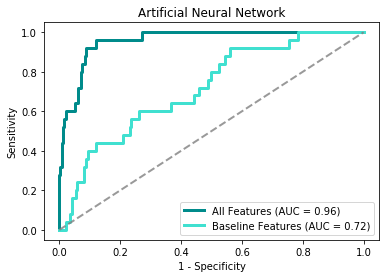

In [21]:
plt.plot(fpr_nn, tpr_nn, lw=3, alpha=1, color='darkcyan',
         label='All Features (AUC = %0.2f)' % auc_nn)
plt.plot(fpr_nnb, tpr_nnb, lw=3, alpha=1, color='turquoise',
         label='Baseline Features (AUC = %0.2f)' % auc_nnb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Artificial Neural Network")
plt.show()


In [22]:
sens_nn = tpr_nn[np.argmin(fpr_nn < 1 - spez)]
acc_nn  = (sens_nn * pos + spez * neg) / len(y)
print('AUC:', auc_nn)
print('Confidence Interval:', wilson_ci (auc_nn, len(y), 0.05))
print('Accuracy:', acc_nn)
print('Sensitivity:', sens_nn)
print('Specificity:', spez)

AUC: 0.9580281690140845
Confidence Interval: [0.935, 0.973]
Accuracy: 0.901108647450111
Sensitivity: 0.92
Specificity: 0.9


In [23]:
sens_nnb = tpr_nnb[np.argmin(fpr_nnb < 1 - spez)]
acc_nnb  = (sens_nnb * pos + spez * neg) / len(y)
print('AUC:', auc_nnb)
print('Confidence Interval:', wilson_ci (auc_nnb, len(y), 0.05))
print('Accuracy:', acc_nnb)
print('Sensitivity:', sens_nnb)
print('Specificity:', spez)

AUC: 0.7167136150234742
Confidence Interval: [0.673, 0.756]
Accuracy: 0.8722838137472284
Sensitivity: 0.4
Specificity: 0.9


In [24]:
from sklearn import svm, datasets
svc = svm.SVC(probability = True, class_weight ={1: 18})

grid_param_svm = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[.0001, .001, .01]}

classifier_svm = GridSearchCV(estimator=svc, param_grid=grid_param_svm, cv=inner_cv, scoring='roc_auc')

In [25]:
probas_svm  = ravel(np.zeros(len(y)))
probas_svmb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_svm.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_svm[test] = probs[:, 1]
    fit = classifier_svm.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_svmb[test] = probs[:, 1]

    
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y, probas_svm)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_svmb, tpr_svmb, thresholds_svmb = roc_curve(y, probas_svmb)
auc_svmb = auc(fpr_svmb, tpr_svmb)

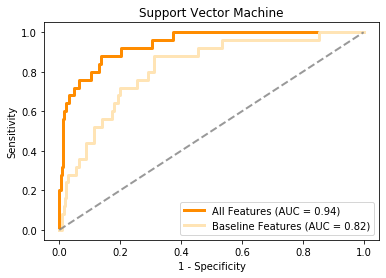

In [26]:
plt.plot(fpr_svm, tpr_svm, lw=3, alpha=1, color='darkorange',
         label='All Features (AUC = %0.2f)' % auc_svm)
plt.plot(fpr_svmb, tpr_svmb, lw=3, alpha=1, color='moccasin',
         label='Baseline Features (AUC = %0.2f)' % auc_svmb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Support Vector Machine")
plt.show()

In [27]:
sens_svm = tpr_svm[np.argmin(fpr_svm < 1 - spez)]
acc_svm  = (sens_svm * pos + spez * neg) / len(y)
print('AUC:', auc_svm)
print('Confidence Interval:', wilson_ci (auc_svm, len(y), 0.05))
print('Accuracy:', acc_svm)
print('Sensitivity:', sens_svm)
print('Specificity:', spez)

AUC: 0.9388732394366198
Confidence Interval: [0.913, 0.957]
Accuracy: 0.892239467849224
Sensitivity: 0.76
Specificity: 0.9


In [28]:
sens_svmb = tpr_svmb[np.argmin(fpr_svmb < 1 - spez)]
acc_svmb  = (sens_svmb * pos + spez * neg) / len(y)
print('AUC:', auc_svmb)
print('Confidence Interval:', wilson_ci (auc_svmb, len(y), 0.05))
print('Accuracy:', acc_svmb)
print('Sensitivity:', sens_svmb)
print('Specificity:', spez)

AUC: 0.8182159624413146
Confidence Interval: [0.78, 0.851]
Accuracy: 0.8745011086474502
Sensitivity: 0.44
Specificity: 0.9


In [29]:
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2



def fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight):
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight=None):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions):
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((np.asarray(predictions_one), np.asarray(predictions_two)))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    return 10**calc_pvalue(aucs, delongcov)

P-values for STS score and all features:

In [30]:
delong_roc_test(y, ravel(sts/100), probas_rf)

array([[1.76430312e-13]])

In [31]:
delong_roc_test(y, ravel(sts/100), probas_svm)

array([[1.8227864e-09]])

In [32]:
delong_roc_test(y, ravel(sts/100), probas_nn)

array([[7.55902876e-11]])

P-values for STS score and baseline features:

In [33]:
delong_roc_test(y, ravel(sts/100), probas_rfb)

array([[7.34342993e-05]])

In [34]:
delong_roc_test(y, ravel(sts/100), probas_svmb)

array([[0.00269182]])

In [35]:
delong_roc_test(y, ravel(sts/100), probas_nnb)

array([[0.23699763]])

P-values for STS2 score and all features:

In [36]:
delong_roc_test(y, ravel(sts_2/100), probas_rf)

array([[1.99874261e-13]])

In [37]:
delong_roc_test(y, ravel(sts_2/100), probas_svm)

array([[1.29544488e-08]])

In [38]:
delong_roc_test(y, ravel(sts_2/100), probas_nn)

array([[2.00321804e-10]])

P-values for STS2 score and baseline features:

In [39]:
delong_roc_test(y, ravel(sts_2/100), probas_rfb)

array([[0.00052598]])

In [40]:
delong_roc_test(y, ravel(sts_2/100), probas_svmb)

array([[0.00460866]])

In [41]:
delong_roc_test(y, ravel(sts_2/100), probas_nnb)

array([[0.34764519]])

P-values within ML methods:

In [42]:
delong_roc_test(y, probas_rf, probas_rfb)

array([[0.0001615]])

In [43]:
delong_roc_test(y, probas_svm, probas_svmb)

array([[0.00963132]])

In [44]:
delong_roc_test(y, probas_nn, probas_nnb)

array([[5.04230179e-07]])